In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import rascals

rascals.setupOorb()
config = rascals.Config()

In [3]:
DATABASE = "../data/objects.db"
con = sql.connect(DATABASE)

**Notes**

_On MJDs and propagation intervals:_

It is important that this algorithm works with exposure times and not nights. This is actually a little trickier than it sounds because the dataset has been simplified to just having a single exposure time for each individual night. 

In the general case, we have a series of observations, at different exposure times $t_i$ in fields centered at ($\alpha_i$, $\delta_i$). To make sure the algorithm works "ground-up" using exposure times, one of the inputs for "rascalization" **needs** to be an array of exposure MJDs with varying intervals.




## Sections
[Plotting Code](#Plotting-Code)  
[Query Code](#Query-Code)  
[Class: Cell](#Class:-Cell)  
[Class: TestParticle](#Class:-TestParticle)  
[Function: rascalize](#Function:-rascalize)  
[Example](#Example)

#### Plotting Code

In [30]:
def _setAxes(ax, coordinateSystem):
    """
    Helper function to set axes limits depending on the coordinate system.
    
    """
    if coordinateSystem == "equatorialAngular":
        ax.set_xlabel(r"$\alpha$ [deg]")
        ax.set_ylabel(r"$\delta$ [deg]")
    elif coordinateSystem == "eclipticAngular":
        ax.set_xlabel(r"$\lambda$ [deg]")
        ax.set_ylabel(r"$\beta$ [deg]")
    elif coordinateSystem == "gnomonic":
        ax.set_xlabel(r"$\theta_X$ [deg]")
        ax.set_ylabel(r"$\theta_Y$ [deg]")
    else:
        raise ValueError("coordinateSystem should be one of: 'equatorialAngular', 'eclipticAngular', 'tangentPlane'")
    ax.set_aspect("equal")
    return

def plotCell(cell,
             coordinateSystem="equatorialAngular",
             scatterKwargs={"s":0.05}):
        
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = cell.observations["RA_deg"].values, 
        y = cell.observations["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = cell.observationst["lon_deg"].values, 
        y = cell.observations["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    #ax.set_xlim(*cell.xRange)
    #ax.set_ylim(*cell.yRange)
    
    cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
    ax.add_artist(cell_p)
    ax.grid()
    return
    
def plotNight(night,
              cell=None,
              coordinateSystem="equatorialAngular",
              scatterKwargs={"s":0.05},
              scatterXlims=(0, 360),
              scatterYlims=(-90, 90)):
    
    fig, ax = plt.subplots(1, 1, dpi=200)
    fig.tight_layout()
    ax.set_aspect("equal")

    if coordinateSystem == "equatorialAngular":
        x = night["RA_deg"].values, 
        y = night["Dec_deg"].values
    elif coordinateSystem == "eclipticAngular":
        x = night["lon_deg"].values, 
        y = night["lat_deg"].values
    else:
        raise ValueError("coordinateSystem should be one of 'equatorialAngular' or 'eclipticAngular'")
    
    _setAxes(ax, coordinateSystem)
    ax.scatter(x, y, **scatterKwargs)
    ax.set_xlim(scatterXlims)
    ax.set_ylim(scatterYlims)

    if cell is not None:
        cell_p = plt.Circle((cell.center[0], cell.center[1]), cell.radius, color="r", fill=False)
        ax.add_artist(cell_p)

    ax.grid()
    return

def plotRascals(dataframe, colorByObject=False, usePlotly=True, returnFig=False):
    if usePlotly is True:
        data = []
        if colorByObject is True:
            for name in dataframe["name"].unique():
                obj = dataframe[dataframe["name"] == name]
                trace = plotly.graph_objs.Scatter(
                    x=obj["theta_x_deg"],
                    y=obj["theta_y_deg"],
                    name=name,
                    mode="lines+markers",
                    marker=dict(size=2,
                                line=dict(width=2))
                )
                data.append(trace)
        else:
            trace = plotly.graph_objs.Scatter(
                x=dataframe["theta_x_deg"],
                y=dataframe["theta_y_deg"],
                mode="markers",
                text=dataframe["name"],
                marker=dict(size=2)
            )
            data.append(trace)
            
        layout = dict(
            width=550,
            height=550,
            autosize=False,
            title="",
            scene=dict(
                xaxis=dict(
                    title="Theta_X [deg]",
                ),
                yaxis=dict(
                    title="Theta_Y [deg]",
                ),
                aspectratio = dict(x=1, y=1)))
        
        fig = plotly.graph_objs.Figure(data=data, layout=layout)
        plotly.offline.iplot(fig)
   
    else:
        fig, ax = plt.subplots(1, 1, dpi=200)
        if colorByObject is True:
            a, b = np.unique(dataframe["name"].values, return_inverse=True)
            hex_map = np.array(sns.color_palette("Accent", len(a)).as_hex())
            c = hex_map[b]
            ax.text(-0.018, 0.016, "Num Objects: {}".format(len(a)), fontsize=8)
        else:
            c = "blue"

        dataframe.plot(x="theta_x_deg", y="theta_y_deg", kind="scatter", c=c, s=0.5, ax=ax)
        _setAxes(ax, "gnomonic")
    
    if returnFig is True:
        if usePlotly is True:
            return fig
        else: 
            return fig, ax

def plotRascals3D(dataframe, colorByObject=False):
    
    data = []
    if colorByObject is True:
        for name in dataframe["name"].unique():
            obj = dataframe[dataframe["name"] == name]
            trace = plotly.graph_objs.Scatter3d(
                x=obj["theta_x_deg"],
                y=obj["theta_y_deg"],
                z=obj["exp_mjd"] - dataframe["exp_mjd"].min(),
                name=name,
                mode="lines+markers",
                marker=dict(size=2,
                            line=dict(width=4))
            )
            data.append(trace)
    else:
        trace = plotly.graph_objs.Scatter3d(
            x=dataframe["theta_x_deg"],
            y=dataframe["theta_y_deg"],
            z=dataframe["exp_mjd"] - dataframe["exp_mjd"].min(),
            mode="markers",
            marker=dict(size=2)
            )
        data.append(trace)

    layout = dict(
        width=800,
        height=550,
        autosize=False,
        title="",
        scene=dict(
            xaxis=dict(
                title="Theta_X [deg]",
            ),
            yaxis=dict(
                title="Theta_Y [deg]",
            ),
            zaxis=dict(
                title="Days [MJD]",
            ),
            aspectratio = dict(x=1, y=1, z=1)))

    fig = plotly.graph_objs.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

#### Query Code

In [31]:
def createQuery(queryType,
                observationColumns=config.observationColumns,
                truthColumns=config.truthColumns):
    if queryType == "observation":
        columns = list(config.observationColumns.values())
    elif queryType == "truth":
        columns = list(config.observationColumns.values()) + list(config.truthColumns.values())
    else:
        raise ValueError("queryType should be one of 'observation' or 'truth'")
    query = '"' + '", "'.join(columns) + '"'
    return query

def queryNight(con,
               night,
               queryType="observation",
               observationColumns=config.observationColumns,
               truthColumns=config.truthColumns):
    
    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    night_df = pd.read_sql("""SELECT {} FROM ephemeris
                              WHERE night = {}""".format(query, night), con)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    night_df.rename(columns=inverseMapping, inplace=True)
    return night_df

def queryCell(con,
              cell,
              queryType="observation",
              chunksize=50000,
              observationColumns=config.observationColumns,
              truthColumns=config.truthColumns):

    query = createQuery(queryType,
                        observationColumns=observationColumns,
                        truthColumns=truthColumns)
    
    chunks = []
    for chunk in pd.read_sql("""SELECT {0} FROM ephemeris
                                 WHERE (({1} >= {2} AND {1} <= {3})
                                 AND ({4} >= {5} AND {4} <= {6})
                                 AND ({7} >= {8} AND {7} <= {9}))""".format(query,
                                                                            observationColumns["exp_mjd"],
                                                                            *cell.mjdRange,
                                                                            observationColumns["RA_deg"],
                                                                            *cell.xRange,
                                                                            observationColumns["Dec_deg"],
                                                                            *cell.yRange), 
                             con,
                             chunksize=chunksize):
        chunks.append(chunk)
    
    cell_df = pd.concat(chunks)
    columnMapping = {**observationColumns, **truthColumns}
    inverseMapping = {value : key for key, value in columnMapping.items()}
    cell_df.rename(columns=inverseMapping, inplace=True)                                                                    

    keep = rascals.findObsInCell(cell_df["obs_id"].values,
                                 cell_df[["RA_deg", "Dec_deg"]].as_matrix(),
                                 cell.center,
                                 cell.radius)
    cell_df = cell_df[cell_df["obs_id"].isin(keep)]
    return cell_df

def getObservations(raRange,
                    decRange,
                    mjdRange,
                    con,
                    queryType="truth",
                    observationColumns=config.observationColumns,
                    truthColumns=config.truthColumns): 
        
        query = createQuery(queryType,
                            observationColumns=observationColumns,
                            truthColumns=truthColumns)
        
        observations = pd.read_sql("""
            SELECT {0} FROM ephemeris
            WHERE (({1} >= {2} AND {1} <= {3})
            AND ({4} >= {5} AND {4} <= {6})
            AND ({7} >= {8} AND {7} <= {9}))
        """.format(query,
                   observationColumns["exp_mjd"],
                   *mjdRange,
                   observationColumns["RA_deg"],
                   *raRange,
                   observationColumns["Dec_deg"],
                   *decRange), con)

        columnMapping = {**observationColumns, **truthColumns}
        inverseMapping = {value : key for key, value in columnMapping.items()}
        observations.rename(columns=inverseMapping, inplace=True)
        print("Found {} observations.".format(len(observations)))
        return observations


#### Class: Cell

In [32]:
class Cell:
    
    def __init__(self, center, radius, mjd, mjd_range=0.5, dataframe=None):
        
        self.center = center
        self.radius = radius
        self.mjd = mjd
        self.mjd_range = mjd_range
        self.dataframe = dataframe
        self.observations = None
        
    def getObservations(self):
        
        observations = self.dataframe
        nightly_observations = observations[(observations["exp_mjd"] >= self.mjd)
                                             & (observations["exp_mjd"] <= self.mjd + self.mjd_range)]
        keep = rascals.findObsInCell(nightly_observations["obs_id"].values,
                                     nightly_observations[["RA_deg", "Dec_deg"]].as_matrix(),
                                     self.center,
                                     self.radius)
        self.observations = nightly_observations[nightly_observations["obs_id"].isin(keep)]

#### Class: TestParticle

In [33]:
class TestParticle:
    def __init__(self, coords_eq_ang, r, velocity_ec_cart, x_e, mjd):
        self.coords_eq_ang = coords_eq_ang
        self.r = r
        self.velocity_ec_cart = velocity_ec_cart
        self.x_e = x_e
        self.mjd = mjd
    
    def prepare(self, verbose=True):
        if verbose is True:
            print("Convering to ecliptic coordinates...")
        self.coords_ec = rascals.coordinates.equatorialToEclipticAngular(np.radians([self.coords_eq_ang]))
        
        if verbose is True:
            print("Calculating asteroid to observer unit vector...")
        self.n_ae = rascals.vectors.calcNae(self.coords_ec[:, 0:2])
        
        if verbose is True:
            print("Calculating asteroid to observer distance assuming r = {} AU...".format(self.r))
        self.delta = rascals.vectors.calcDelta(self.r, self.x_e, self.n_ae)
        
        if verbose is True:
            print("Calculating asteroid to observer position vector...")
        self.x_ae = rascals.vectors.calcXae(self.delta, self.n_ae)
        
        if verbose is True:
            print("Calculating barycentic asteroid position vector...")
        self.x_a = rascals.vectors.calcXa(self.x_ae, self.x_e)
        
        if verbose is True:
            print("Calculating R1 rotation matrix...")
        self.R1 = rascals.vectors.calcR1(self.x_a)
        self.x_a_xy = np.array(self.R1 @ self.x_a)[0]
        
        if verbose is True:
            print("Calculating R2 rotation matrix...")
        self.R2 = rascals.vectors.calcR2(self.x_a_xy)
        
        if verbose is True:
            print("Calculating final rotation matrix...")
        self.M = self.R2 @ self.R1
        
        if verbose is True:
            print("Done.")
            print("")
        return
        
    def apply(self, cell, verbose=True):
        
        if verbose is True:
            print("Convering to ecliptic coordinates...")
        coords_ec = rascals.coordinates.equatorialToEclipticAngular(np.radians(cell.observations[["RA_deg", "Dec_deg"]].as_matrix()))
        
        if verbose is True:
            print("Calculating asteroid to observer unit vector...")
        n_ae = rascals.vectors.calcNae(coords_ec)
        x_e = cell.observations[["obs_x_au", "obs_y_au", "obs_z_au"]].as_matrix()
        
        if verbose is True:
            print("Calculating asteroid to observer distance assuming r = {} AU...".format(self.r))
        delta = np.zeros(len(n_ae))
        for i, (n_ae_i, x_e_i) in enumerate(zip(n_ae, x_e)):
            delta[i] = rascals.vectors.calcDelta(self.r, x_e_i, n_ae_i)
        
        if verbose is True:
            print("Calculating asteroid to observer position vector...")
        x_ae = np.zeros([len(delta), 3])
        for i, (delta_i, n_ae_i) in enumerate(zip(delta, n_ae)):
            x_ae[i] = rascals.vectors.calcXae(delta_i, n_ae_i)
        
        if verbose is True:
            print("Calculating barycentic asteroid position vector...")
        x_a = np.zeros([len(x_ae), 3])
        for i, (x_ae_i, x_e_i) in enumerate(zip(x_ae, x_e)):
            x_a[i] = rascals.vectors.calcXa(x_ae_i, x_e_i)
        
        if verbose is True:
            print("Applying rotation matrix M to barycentric asteroid position vector...")
        coords_cart_rotated = np.array(self.M @ x_a.T).T
        
        if verbose is True:
            print("Performing gnomonic projection...")
        gnomonic = rascals.projections.cartesianToGnomonic(coords_cart_rotated)
        
        cell.observations["theta_x_deg"] = np.degrees(gnomonic[:, 0])
        cell.observations["theta_y_deg"] = np.degrees(gnomonic[:, 1])

        if verbose is True:
            print("Done.")
            print("")
        return 

#### Function: rascalize

In [34]:
def rascalize(cell, particle, mjds, mjd_range=0.5, verbose=True):
    # If initial doesn't have observations loaded,
    # get them
    if cell.observations is None:
        cell.getObservations()
    
    # Prepare transformation matrices
    particle.prepare(verbose=verbose)
    
    # Apply tranformations to observations
    particle.apply(cell, verbose=verbose)
    
    # Add initial cell and particle to lists
    cells = [cell]
    particles = [particle]
    
    # Initialize final dataframe and add observations
    final_df = pd.DataFrame()
    final_df = pd.concat([cell.observations, final_df])
    
    for mjd_f in mjds[1:]:
        oldCell = cells[-1]
        oldParticle = particles[-1]
        
        # Propagate particle to new mjd
        propagated = rascals.propagateTestParticle(oldParticle.x_a,
                                                   oldParticle.velocity_ec_cart,
                                                   oldParticle.mjd,
                                                   mjd_f,
                                                   verbose=verbose)
        # Get new equatorial coordinates
        new_coords_eq_ang = propagated[["RA_deg", "Dec_deg"]].as_matrix()[0]
        
        # Get new barycentric distance
        new_r = propagated["r_au"].values[0]
        
        # Get new velocity in ecliptic cartesian coordinates
        new_velocity_ec_cart = propagated[["HEclObj_dX/dt_au_p_day",
                                           "HEclObj_dY/dt_au_p_day",
                                           "HEclObj_dZ/dt_au_p_day"]].as_matrix()[0]
        
        # Get new location of observer
        new_x_e = propagated[["HEclObsy_X_au",
                              "HEclObsy_Y_au",
                              "HEclObsy_Z_au"]].as_matrix()[0]
        
        # Get new mjd (same as mjd_f)
        new_mjd = propagated["mjd_utc"].values[0]

        # Define new cell at new coordinates
        newCell = Cell(new_coords_eq_ang,
                       oldCell.radius,
                       new_mjd,
                       dataframe=oldCell.dataframe)
        
        # Get the observations in that cell
        newCell.getObservations()
        
        # Define new particle at new coordinates
        newParticle = TestParticle(new_coords_eq_ang,
                                   new_r,
                                   new_velocity_ec_cart,
                                   new_x_e,
                                   new_mjd)
        
        # Prepare transformation matrices
        newParticle.prepare(verbose=verbose)
       
        # Apply tranformations to new observations
        newParticle.apply(newCell, verbose=verbose)
        
        # Add observations to final dataframe
        final_df = pd.concat([newCell.observations, final_df])
        
        # Append new cell and particle to lists
        cells.append(newCell)
        particles.append(newParticle)
        
    return final_df, cells, particles

#### Example

Let us see what a night of data looks like

In [9]:
night = queryNight(con, 59582)

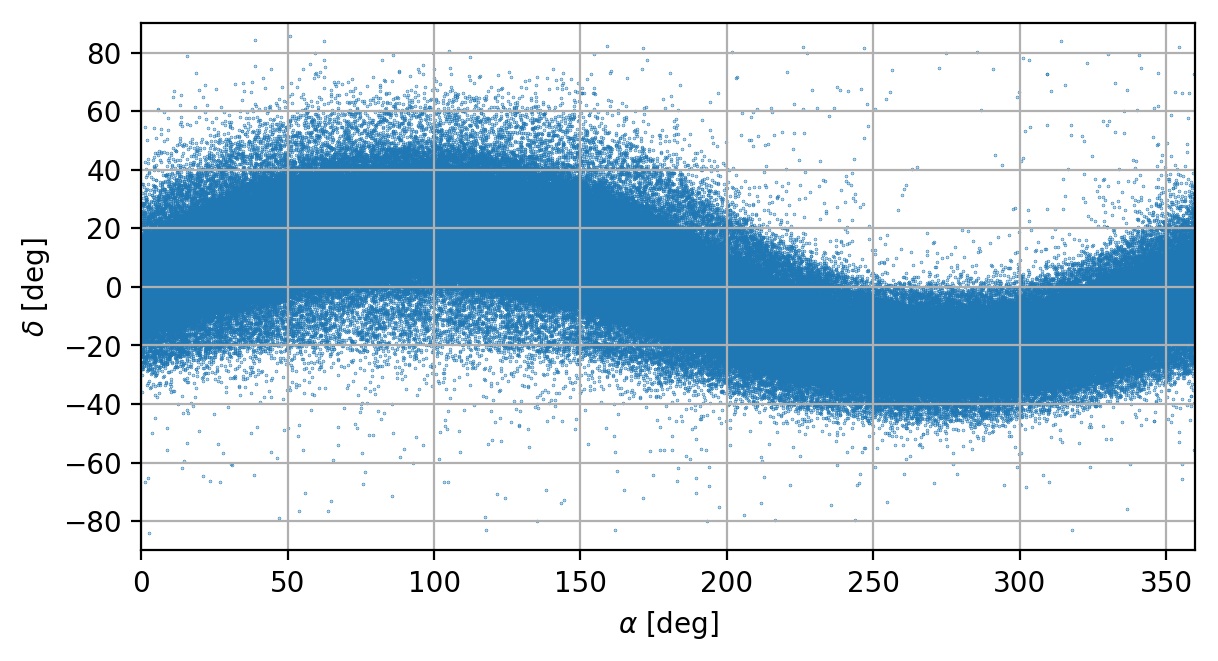

In [10]:
plotNight(night)

Load some 'observations' into a dataframe

In [11]:
raRange = [150, 250]
decRange = [-40, 0]
mjdRange = [59582, 59582 + 10]
observations = getObservations(raRange, decRange, mjdRange, con)

Found 1732176 observations.


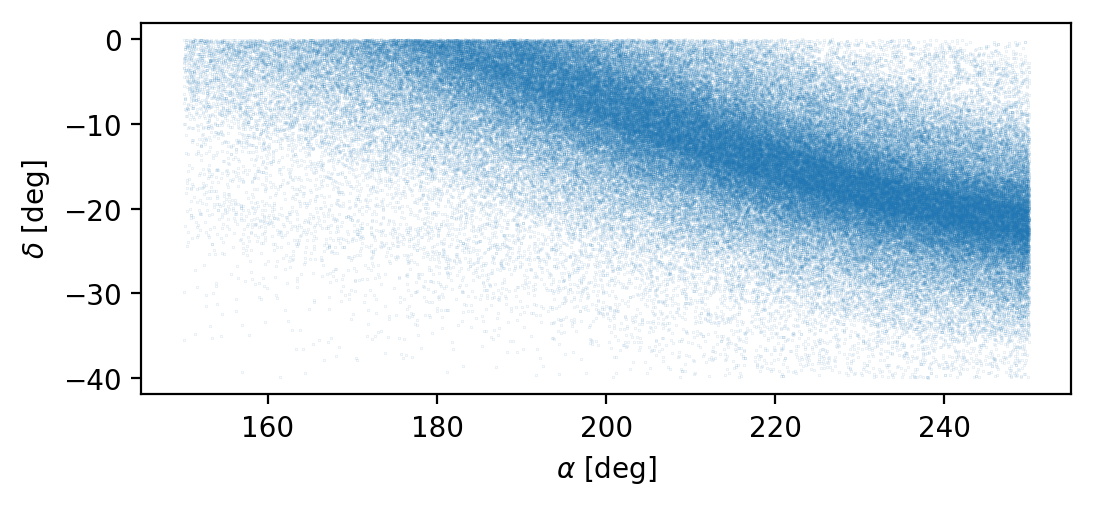

In [12]:
ra = observations[observations["night"] == 59582]["RA_deg"].values
dec = observations[observations["night"] == 59582]["Dec_deg"].values

fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(ra, dec, s=0.001)
_setAxes(ax, "equatorialAngular")
ax.set_aspect("equal")

Define an initial cell

In [13]:
cell = Cell([199.8, -19.8], 1.0, 59582, dataframe=observations)
cell.getObservations()

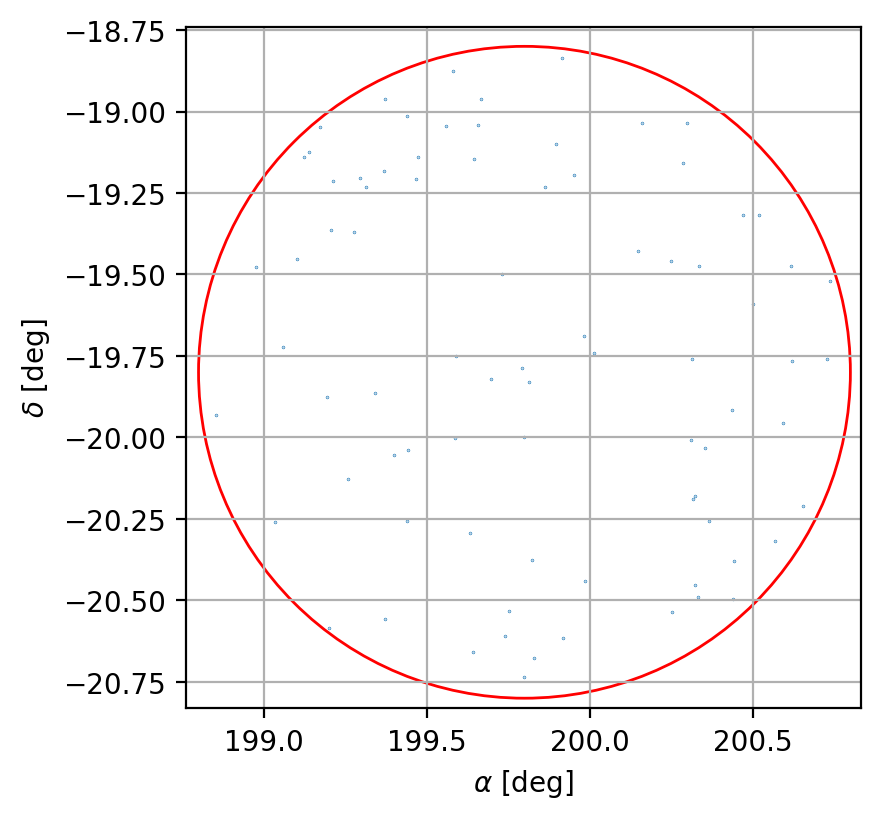

In [14]:
plotCell(cell)

In [15]:
print("r [AU]:\n min: {}\n max: {}\n median: {}".format(cell.observations["r_au"].min(),
                                                        cell.observations["r_au"].max(),
                                                        cell.observations["r_au"].median()))

r [AU]:
 min: 1.8270287254
 max: 4.667717103399999
 median: 2.9000345029


In [16]:
# For now lets take the object which has the median barycentric distance, lets also grab its velocity
real_object = cell.observations[cell.observations["name"] == "U3160"]
velocity_ec_cart = real_object[["obj_dx/dt_au_p_day", "obj_dy/dt_au_p_day", "obj_dz/dt_au_p_day"]].as_matrix()[0]
x_e = real_object[["obs_x_au","obs_y_au", "obs_z_au"]].as_matrix()[0]
r = real_object["r_au"].values[0]
mjd = real_object["exp_mjd"].values[0]

In [18]:
cell = Cell([199.8, -19.8], 1.0, 59582, dataframe=observations)
particle = TestParticle(cell.center, r, velocity_ec_cart, x_e, mjd)
mjds = observations["exp_mjd"].unique()

In [19]:
rascals_df, cells, particles = rascalize(cell, particle, mjds, verbose=False)

In [35]:
plotRascals(rascals_df)

In [36]:
plotRascals(rascals_df, colorByObject=True)

In [22]:
plotRascals3D(rascals_df)

In [23]:
plotRascals3D(rascals_df, colorByObject=True)

In [77]:
def animateRascals(cell, particle, mjds, r_range, r_step=0.1, colorByObject=False):
    
    frames = []
   
    for r in np.arange(r_range[0], r_range[1]+r_step, r_step):
        particle.r = r
        dataframe, cells, particles = rascalize(cell, particle, mjds, verbose=False)
        
        data = []
        if colorByObject is True:
            for name in dataframe["name"].unique():
                obj = dataframe[dataframe["name"] == name]
                trace = plotly.graph_objs.Scatter(
                    x=obj["theta_x_deg"],
                    y=obj["theta_y_deg"],
                    name=name,
                    mode="lines+markers",
                    marker=dict(size=2,
                                line=dict(width=2))
                )
                data.append(trace)
        else:
            trace = plotly.graph_objs.Scatter(
                x=dataframe["theta_x_deg"],
                y=dataframe["theta_y_deg"],
                mode="markers",
                text=dataframe["name"],
                marker=dict(size=2)
            )
            data.append(trace)
            
        layout = dict(
            width=550,
            height=550,
            autosize=False,
            title="",
            scene=dict(
                xaxis=dict(
                    title="Theta_X [deg]",
                ),
                yaxis=dict(
                    title="Theta_Y [deg]",
                ),
                aspectratio = dict(x=1, y=1)),
            updatemenus= [{'type': 'buttons',
                           'buttons': [{'label': 'Play',
                                        'method': 'animate',
                                        'args': [None]}]}])
        
    
        
        frames.append({"data" : data})
    fig = plotly.graph_objs.Figure(data=frames[0]["data"], layout=layout, frames=frames[1:])
    plotly.offline.plot(fig)
        
    return 

In [78]:
cell = Cell([199.8, -19.8], 1.0, 59582, dataframe=observations)
particle = TestParticle(cell.center, r, velocity_ec_cart, x_e, mjd)
mjds = observations["exp_mjd"].unique()

In [79]:
animateRascals(cell, particle, mjds, [2.0, 2.2])